# HDBSCAN should work well on embedding representations

In [1]:
import os
import re
import json
import hdbscan

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from collections import Counter
import matplotlib.pyplot as plt

import lib.helper as helper
import lib.reporter as reporter
import lib.embedding_models as reps

from gensim.models import Word2Vec

%matplotlib inline

## 1.  Retrieve Corpus

The corpus is being scraped by the "run_news_scrapes.py" script (and windows task scheduler) every 12 hours, a bit past midday and a bit past midnight.

The "bing" corpus are news titles and text extracts gotten from the bing news search API, using a few Home Office - related keywords.

The "RSS" corpus is plugged directly into a number of RSS feeds for world news sites and local british news sites, with no filters for news story types or subjects applied.

In [2]:
# Should be same path for all my PC's, it's where each scrape goes as a separate json file.
storage_path = "D:/Dropbox/news_crow/scrape_results"

# "bing" is targeted news search corpus, "RSS" is from specific world and local news feeds.
corpus_type = "disaster"

# Load up
corpus = helper.load_clean_corpus(storage_path, corpus_type)

# Make sure after cleaning etc it's indexed from 0
corpus.reset_index(inplace=True)
corpus.index.name = "node"

# See how it turned out
print(corpus.shape)
corpus.head()

Total files: 331
10.0 percent of files read.
19.9 percent of files read.
29.9 percent of files read.
39.9 percent of files read.
49.8 percent of files read.
59.8 percent of files read.
69.8 percent of files read.
79.8 percent of files read.
89.7 percent of files read.
99.7 percent of files read.
(23554, 9)


,index,title,summary,date,link,source_url,retrieval_timestamp,origin,clean_text
node,,,,,,,,,
0,0,West Midlands <b>flood</b> warnings prompt &#3...,Residents have been warned to &quot;remain vig...,2019-11-17T17:35:00.0000000Z,https://www.bbc.co.uk/news/uk-england-50451817,www.bbc.co.uk,2019-11-17 19:50:58.278878,bing_news_api,West Midlands flood warnings prompt remain vig...
1,1,New <b>flood</b> warnings issued with more hom...,The Environment Agency has a number of <b>floo...,2019-11-17T18:35:00.0000000Z,https://www.hulldailymail.co.uk/news/hull-east...,www.hulldailymail.co.uk,2019-11-17 19:50:58.278928,bing_news_api,New flood warnings issued with more homes at r...
2,2,UK weather forecast – More than 100 <b>flood</...,<b>FLOOD</b>-ravaged villages in the UK have b...,2019-11-17T13:45:00.0000000Z,https://www.thesun.co.uk/news/10342583/uk-weat...,www.thesun.co.uk,2019-11-17 19:50:58.278953,bing_news_api,UK weather forecast – More than 1 flood alerts...
3,5,UK <b>flood</b> warning map: <b>Flood</b> chao...,The Environment Agency has issued 57 <b>flood<...,2019-11-17T16:38:00.0000000Z,https://www.express.co.uk/news/weather/1205629...,www.express.co.uk,2019-11-17 19:50:58.279028,bing_news_api,UK flood warning map: Flood chaos to continue ...
4,6,UK weather forecast: <b>Flood</b> chaos contin...,Despite some areas enduring their &#39;wettest...,2019-11-17T18:32:00.0000000Z,https://www.mirror.co.uk/news/uk-news/uk-weath...,www.mirror.co.uk,2019-11-17 19:50:58.279047,bing_news_api,UK weather forecast: Flood chaos continues wit...


## 2.  Build Text Model (Representation, eg; word2vec, entities list...)

- Trying with the world corpus and with the bing corpus, neither worked with InferSent.  Suspect the problem lies in the PCA step, which may not be working well on this high-dimensional (vector length = 4096) form.
- Summed keywords works rather better with the world corpus.
- Summed keywords still fail the bing/home office corpus, giving me a cluster about "immigration" and a cluster for the American Supreme Court.

## 2a.  Try a really simple averaged word vector model!

With a complex noun extraction function 'cause that part's slow so I multi-threaded it.

In [3]:
vec_size = 100

# Get phrase-conjoined, stem tokens
corpus['phrase_tokens'] = helper.get_phrased_nouns(corpus['clean_text'])

# Detect and conjoin bigrams
model = Word2Vec(corpus['phrase_tokens'], size=vec_size, window=5, min_count=5, workers=10)

In [4]:
def get_averaged_vec(token_list, model):
    
    vecs = []
    for token in token_list:
        try:
            vector = model.wv[token]
        except: 
            vector = np.zeros(vec_size)
        vecs.append(vector)
    
    if len(vecs) > 0:
        return np.mean(np.asarray(vecs), axis=0)
    else:
        return np.zeros(vec_size)

In [5]:
vectors = [get_averaged_vec(tokens, model) for tokens in corpus['phrase_tokens']]

## 3. Cluster Text

This is the part where the pipelines get a little more experimental
- First; PCA (HDBSCAN prefers < 50 dimensions if possible) (also, try just fitting 50 vectors!)
- Second; HDBSCAN clustering

In [6]:
embeddings_array = np.vstack(vectors)

# First, PCA the data
pca = PCA(n_components=20, svd_solver='full')

# Fit and check
embeddings_pca = pca.fit_transform(embeddings_array)

# Diagnostic stats - both should show exponential decay
print(pca.explained_variance_ratio_)
print(pca.singular_values_) 

[9.85691591e-01 1.11066158e-02 1.94773877e-03 3.39060056e-04
 2.07157187e-04 1.08944088e-04 8.07189182e-05 4.69793768e-05
 3.78159801e-05 3.38441852e-05 2.47173410e-05 2.19743626e-05
 1.85809521e-05 1.69681775e-05 1.39330895e-05 1.32136495e-05
 1.13084593e-05 1.06114021e-05 9.95453992e-06 9.30638258e-06]
[148.5660378   15.77029762   6.60411109   2.75541698   2.15376848
   1.56189146   1.34442532   1.02565816   0.92020946   0.87054464
   0.74396052   0.70146686   0.64503458   0.61640566   0.55856373
   0.54395179   0.50321171   0.48745598   0.47212784   0.45649862]


In [7]:
# Clusterer fitting
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=10)
clusterer.fit(embeddings_array)

# Diagnostic - calculate percentage of records assigned "outlier"
print("Percent outlier: ", 100.0 * sum(clusterer.labels_ == -1) / clusterer.labels_.shape[0])

# number of clusters created
print("Number of clusters: ", len(pd.unique(clusterer.labels_)))

# Record cluster each was assigned to
corpus['cluster'] = clusterer.labels_

# Record the reverse of outlier score (therefore, higher number = higher certainty of membership)
corpus['score'] = 1.0 - clusterer.outlier_scores_

corpus.to_csv("working/disaster_clustered_w2v_direct.csv", index=False)

Percent outlier:  57.11980979876029
Number of clusters:  100


C:\ProgramData\Anaconda3\lib\site-packages\hdbscan\hdbscan_.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self._outlier_scores = outlier_scores(self._condensed_tree)


In [13]:
# For calculating silhouette score, a gauge of how well separated clusters
# are in some spatial representation
from sklearn.metrics import silhouette_score

# Filter out the outliers
embeddings_score = embeddings_pca[clusterer.labels_ != -1]
labels_score = clusterer.labels_[clusterer.labels_ != -1]

score = silhouette_score(embeddings_score, labels_score, metric="cosine")
score

-0.00710643209164836

In [14]:
Counter(clusterer.labels_)

Counter({-1: 17345,
         8: 59,
         129: 2290,
         127: 19,
         128: 892,
         95: 45,
         88: 5,
         85: 14,
         10: 24,
         101: 40,
         126: 47,
         42: 15,
         112: 56,
         20: 14,
         27: 9,
         122: 43,
         45: 565,
         54: 5,
         34: 6,
         14: 40,
         55: 8,
         94: 24,
         69: 6,
         100: 23,
         15: 15,
         123: 25,
         7: 19,
         33: 5,
         118: 18,
         120: 58,
         19: 17,
         59: 5,
         12: 19,
         84: 22,
         24: 5,
         28: 33,
         82: 26,
         79: 39,
         31: 6,
         56: 8,
         64: 16,
         29: 13,
         1: 18,
         113: 19,
         62: 17,
         35: 7,
         6: 5,
         43: 9,
         51: 40,
         0: 13,
         52: 12,
         16: 5,
         67: 7,
         44: 22,
         78: 13,
         111: 7,
         58: 42,
         48: 20,
         30: 6,


c_v 0.594
c_npmi 0.0886
macro_time_coherence 1174006.9822486006
micro_time_coherence 143825.4968452203
Average document word count 59.611870595227984
Number of documents 23554
Latest record 1970-01-01T01:00:00.0000000Z
Earliest record 2020-07-01T09:21:00.0000000Z
Number of clusters 131
Median cluster size 14.0
Percent clustered docs 26.4


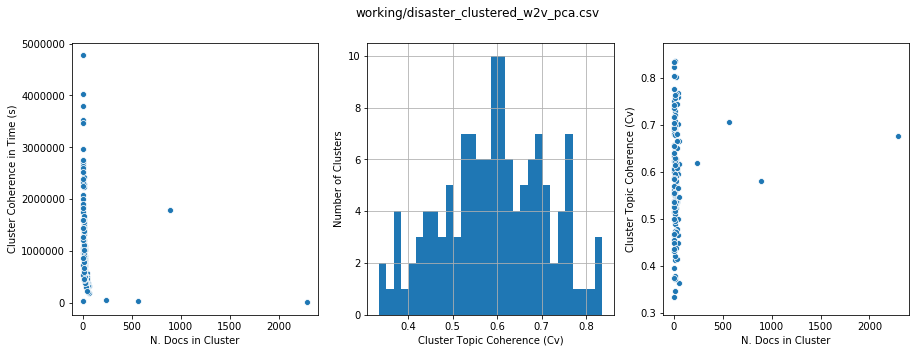

In [15]:
corpus = pd.read_csv("working/disaster_clustered_w2v_pca.csv")
stats, coherences, results = reporter.report_corpus_model_coherence("working/disaster_clustered_w2v_pca.csv")

for key, value in stats.items():
    if "examples" not in key:
        print (key, value)

## 4. Cluster text with Spectral Clustering
Not working on high-dimensional data

## 5. Cluster text with Kmeans

Percent outlier:  0.0
Number of clusters:  200
c_v 0.6046
c_npmi 0.0929
macro_time_coherence 556335.9446510379
micro_time_coherence 290173.4966901973
Average document word count 59.611870595227984
Number of documents 23554
Latest record 1970-01-01T01:00:00.0000000Z
Earliest record 2020-07-01T09:21:00.0000000Z
Number of clusters 199
Median cluster size 74.0
Percent clustered docs 100.0


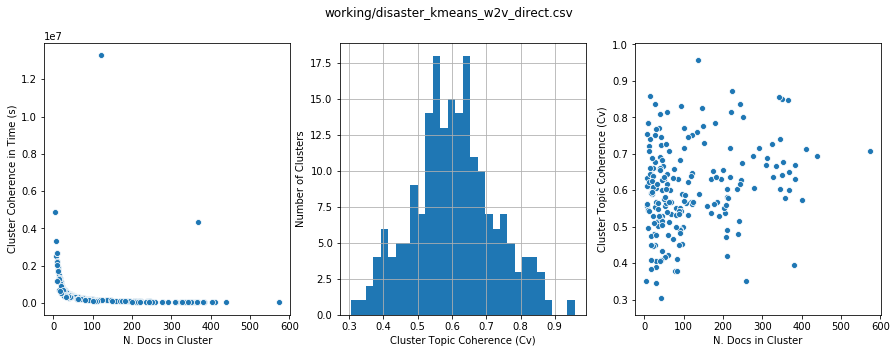

In [16]:
#from nltk.cluster.kmeans import KMeansClusterer
from sklearn.cluster import KMeans

#kmc = KMeansClusterer(num_means=60, distance=cosine_similarity)
#clusters = kmc.cluster(embeddings_array, True, trace=True)
#clusters

kmeans = KMeans(n_clusters=200, random_state=0).fit(embeddings_array)

# Diagnostic - calculate percentage of records assigned "outlier"
print("Percent outlier: ", 100.0 * sum(kmeans.labels_ == -1) / kmeans.labels_.shape[0])

# number of clusters created
print("Number of clusters: ", len(pd.unique(kmeans.labels_)))

# Record cluster each was assigned to
corpus['cluster'] = kmeans.labels_

# Record the reverse of outlier score (therefore, higher number = higher certainty of membership)
corpus['score'] = 1.0

# If cluster is smaller than minimum limit, designate as outlier
cs_lookup = corpus['cluster'].value_counts().to_dict()
corpus['cluster'] = corpus['cluster'].apply(lambda x: -1 if (cs_lookup[x] < 5) else x)

corpus.to_csv("working/disaster_kmeans_w2v_direct.csv", index=False)

stats, coherences, results = reporter.report_corpus_model_coherence("working/disaster_kmeans_w2v_direct.csv")

for key, value in stats.items():
    if "examples" not in key:
        print (key, value)

Percent outlier:  0.0
Number of clusters:  200
c_v 0.607
c_npmi 0.0918
macro_time_coherence 497325.0227573975
micro_time_coherence 288374.46495119523
Average document word count 59.611870595227984
Number of documents 23554
Latest record 1970-01-01T01:00:00.0000000Z
Earliest record 2020-07-01T09:21:00.0000000Z
Number of clusters 197
Median cluster size 65.5
Percent clustered docs 99.9


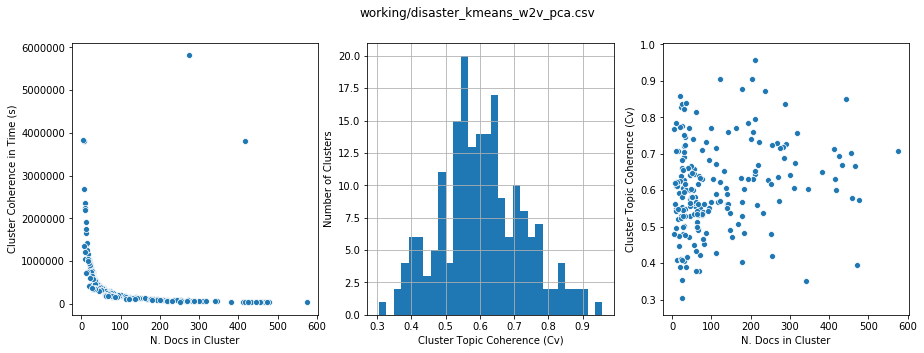

In [17]:
#from nltk.cluster.kmeans import KMeansClusterer
from sklearn.cluster import KMeans

#kmc = KMeansClusterer(num_means=60, distance=cosine_similarity)
#clusters = kmc.cluster(embeddings_array, True, trace=True)
#clusters

kmeans = KMeans(n_clusters=200, random_state=0).fit(embeddings_pca)

# Diagnostic - calculate percentage of records assigned "outlier"
print("Percent outlier: ", 100.0 * sum(kmeans.labels_ == -1) / kmeans.labels_.shape[0])

# number of clusters created
print("Number of clusters: ", len(pd.unique(kmeans.labels_)))

# Record cluster each was assigned to
corpus['cluster'] = kmeans.labels_

# Record the reverse of outlier score (therefore, higher number = higher certainty of membership)
corpus['score'] = 1.0

# If cluster is smaller than minimum limit, designate as outlier
cs_lookup = corpus['cluster'].value_counts().to_dict()
corpus['cluster'] = corpus['cluster'].apply(lambda x: -1 if (cs_lookup[x] < 5) else x)

corpus.to_csv("working/disaster_kmeans_w2v_pca.csv", index=False)

stats, coherences, results = reporter.report_corpus_model_coherence("working/disaster_kmeans_w2v_pca.csv")

for key, value in stats.items():
    if "examples" not in key:
        print (key, value)